# Predicting Early Prediction of Patient MET call at the time of admission


## Table of Contents

* [1. __Prepare Problem__](#heading--1)
  * [1.1. Load libraries](#heading--1-1)
  * [1.2. Load dataset](#heading--1-2)
  * [1.3. Describe the data](#heading--1-3)
  * [1.4. Imbalanced dataset](#heading--1-4)
* [2. __Data preparation__](#heading--2)
  * [2.1. Data cleanup](#heading--2-I)
  * [2.2. Feature Selection](#heading--2-II)
* [3. __Imbalanced Classification__](#heading--III)
  * [3.1. Model comparison](#heading--3-I)
  * [3.2. Hyperparameter Tuning](#heading--3-II)

<a class="anchor" id="heading--1"></a>
## 1. __Prepare Problem__


<a class="anchor" id="heading--1-1"></a>
## 1.1. __Load libraries__

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sys
import glob
import os
import gc
##from data_prepare                  import data_prep
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import pandas                      as pd
from utils.data_cleanup            import mimic_cleanup
from utils.utils                   import groupby_,PRC_models,gc_models
from utils.utils                   import make_confusion_matrix, validate_the_model
from utils.utils                   import prepare_dta_file, Train_Test_Split
from utils.utils                   import result_display, train_save_model_model
from tqdm.notebook                 import tqdm # progressbar
from time                          import sleep
from imblearn.under_sampling       import InstanceHardnessThreshold
from imblearn.pipeline             import Pipeline
from imblearn.pipeline             import make_pipeline
from imblearn.ensemble             import BalancedBaggingClassifier
from imblearn.ensemble             import BalancedRandomForestClassifier
from imblearn.ensemble             import EasyEnsembleClassifier

from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.preprocessing         import MinMaxScaler
from sklearn.model_selection       import cross_validate
from sklearn.model_selection       import KFold
from sklearn.model_selection       import RepeatedStratifiedKFold
from sklearn.model_selection       import cross_val_score
from sklearn.model_selection       import GridSearchCV
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import recall_score
from sklearn.metrics               import make_scorer
from sklearn.metrics               import fbeta_score
from sklearn.linear_model          import LogisticRegression 
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.naive_bayes           import ComplementNB
from sklearn.utils.class_weight    import compute_class_weight
from sklearn.svm                   import SVC
from sklearn.feature_selection     import SelectKBest
from sklearn.feature_selection     import chi2
from sklearn.feature_selection     import RFE
from sklearn.ensemble              import RandomForestClassifier
from sklearn.ensemble              import ExtraTreesClassifier
from sklearn.compose               import ColumnTransformer
from category_encoders             import MEstimateEncoder


from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.reset_option('all')
%matplotlib inline
data_path = '../../data_2021-may-15/'

# separate X and Y
CM_labels = ['True Neg','False Pos','False Neg','True Pos']
CM_categories = ['Zero', 'One']

# name of dependant variable
target = 'met'

# list of dependant columns
prediction_output_list = ['met','cb', 'anycall','died', 'LOS']
drop_list = [col for col in prediction_output_list if col != target]


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



<a class="anchor" id="heading--1-2"></a>
### 1.2. __Load dataset__

In [2]:
# load @admission file based on 1~167 csv files 
df =  pd.read_csv(data_path+'@admission_allData.csv', low_memory=False)
print('Dataset loaded successfully.\nDimensions of the dataset: {}'.format(df.shape))


Dataset loaded successfully.
Dimensions of the dataset: (163273, 145)


<div id="heading--1-3"/>

### 1.3. __Describe the data__

In [3]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df.head(2))

,Unnamed: 0,dt,visit,urno,age,sex,indig,cadttext,cward,cbed,cunit,csource,cadmitclass,cpvthlth,cadmitmbs,cexpstay,evisit,ecomplaintcode,ecomplaint,etriage,cicu,ctheatre,pvisit,padmdtext,punit,plos,pcomorbid,ageadmission,agerisk,combinedscore,survive10,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,pdiag,pdiagd,pproc,pprocd,pcall,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,postcode,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,atrisk,id,frailty,rdt,cadt,padt,sequence,outcome,wies,drg,icd10,diagnosis,dobt,dodt,admitdt,adt,ad,dischargedt,ddt,dd,died,dob,dod,call,eventdate,met,cb,arrest,anycall,hiout,anyarrest,charlsum,charl2,edvisit,ipany,edany,period,sequencelos,phc,bicarbc,lactatec,hbc,wccc,creatininec,plateletsc,phc2,bicarbc2,lactatec2,hbc2,wccc2,creatininec2,plateletsc2,male,unitcode,statin,transin,nhin,pmet,charl3,vascular,stroke,respiratory,renal,nsurg,genmed,cts,gensurg,ort,ent,card,elective,elective2,outlier,frail3,frail2
0,0.0,2019-07-23 15:01:37,897520,1226958.0,72.845990,F,0,2019-07-23 14:53:09,MTC,,N/L,HME,EAD,0,,0,NaN,NaN,NaN,NaN,0,0,8342444.0,2018-05-22 00:00:00,GAS,0,1.0,71.0,3.0,4.0,0.534,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,R19.5,Other faecal abnormalities,32090-00,Fibreoptic colonoscopy to caecum,NaN,0,7.4,25,1.5,119,4.7,75,152,3071.0,7.0,7.0,3.0,9.0,0,1,0,0,NaN,8674490,0.0,2019-07-23 15:00:35.456,2019-07-23 14:54:02.240,2018-05-21 23:59:57.952,1,H,Same Day Wgt,Q61B,D50.9,"Iron deficiency anaemia, unspecified",19460917,NaN,2019-07-23 14:53:09,2019-07-23 14:54:02.240,2019-07-23 00:00:00.000,2019-07-23 16:21:27,2019-07-23 16:21:25.120,2019-07-23 00:00:00.000,No,1946-09-17,NaN,0,NaN,0,0,0,0,No,0,1,0,No,0,0,NaN,2,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0,0,N/L,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.0,Yes,Normal,Normal
1,2.0,2018-04-09 07:01:39,962323,438854.0,72.210815,F,0,2018-04-09 06:34:20,10W,,N/S,HWL,EAD,0,40303,7,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,7.4,25,1.5,120,9.0,90,250,3055.0,7.0,7.0,2.0,9.0,0,0,0,0,NaN,5112909,NaN,2018-04-09 07:00:59.008,2018-04-09 06:34:46.144,NaN,1,S,Inlier Wgt,I10A,M50.0,Cervical disc disorder with myelopathy,19460122,NaN,2018-04-09 06:34:20,2018-04-09 06:34:46.144,2018-04-09 00:00:00.000,2018-04-16 11:34:31,2018-04-16 11:33:29.216,2018-04-16 00:00:00.000,No,1946-01-22,NaN,0,NaN,0,0,0,0,No,0,0,0,No,0,0,NaN,172,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0,0,N/S,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0,No,Normal,Normal


<div id="heading--1-4"/>

### 1.4. __Imbalanced dataset__

    * Check out data imbalance  

The met classes follows an imbalance distribution since the majority of patients have met=0 (98%).

In [4]:
for col, col_name in zip([target],[target]):
    df.loc[df['met'] > 0, 'met'] = 1
    groupby_(df, col, col_name)


,#met,+,%
0,0,160176,98.103177
1,1,3097,1.896823


<a class="anchor" id="heading--2"></a>
## 2. Data preparation

<a class="anchor" id="heading--2-I"></a>
###  2.1. __Data cleanup__

The `mimic_cleanup` performs all of the needed data cleanup and feature engineering steps. 

* __Apply data cleanup__

In [5]:
# apply preprocessing
df, categorical_ix = mimic_cleanup(df)

# drop other dependant variables
df_met = df.drop(drop_list, axis=1)

(1/10) Completed training purpose data engineering
(2/10) Completed renaming columns
(3/10) Completed filtering columns
(4/10) Completed postcode (Feature Engineering).
(5/10) Completed Feature Engineering
(6/10) Completed Droping useless columns
(7/10) Completed missing value handeling
(8/10) Completed data type conversion
(9/10) Completed data type conversion
(10/10) Completed data type conversion
Data Preprocessing complete.
Total Number of remained missing values --> 0
Dimensions of the final dataset: (163273, 59)



* __Display preprocessed data__

In [6]:

with pd.option_context('display.max_colum', None):
    display(df_met.tail(1))
df_met.shape

,cward,cunit,ecomplaintcode,pdiag,indig,cpvthlth,cexpstay,etriage,cicu,ctheatre,pcomorbid,agerisk,combinedscore,survive10,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,frailty,met,sa4,male,elective,age_range,outlier,csource_E,csource_HME,csource_HWL,csource_N,csource_R,csource_S,csource_T,csource_TRC,csource_zPN,cadmitclass_EAD,cadmitclass_EMD,cadmitclass_O,cadmitclass_S,state_-1,state_ACT,state_NSW,state_NT,state_QLD,state_SA,state_TAS,state_VIC,state_WA
163272,EOU,ESS,-1,-1,0,1,999,0,0,0,-1,-1,-1,-1.0,0,7.4,25,1.5,173,6.5,81,236,3,1,1,9,-1.0,0,206,1,0,6,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


(163273, 55)

* __Splitting Data__

In [7]:
df_train, df_test = train_test_split(df_met,  stratify = df_met[target],
                                     test_size = 0.3,
                                     random_state = 42)
# Train and test split
X_train, y_train = df_train.drop(  [target], axis=1) , df_train  [target]
X_test,  y_test  = df_test.drop([target], axis=1) , df_test[target]


* __define encoder and scaler__

In [8]:
encoder = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), categorical_ix )], remainder='passthrough')
scaler  = MinMaxScaler()

<a class="anchor" id="heading--2-II"></a>
### 2.2 Feature Selection
* __methods generating under-sampled subsets combined inside an ensemble__

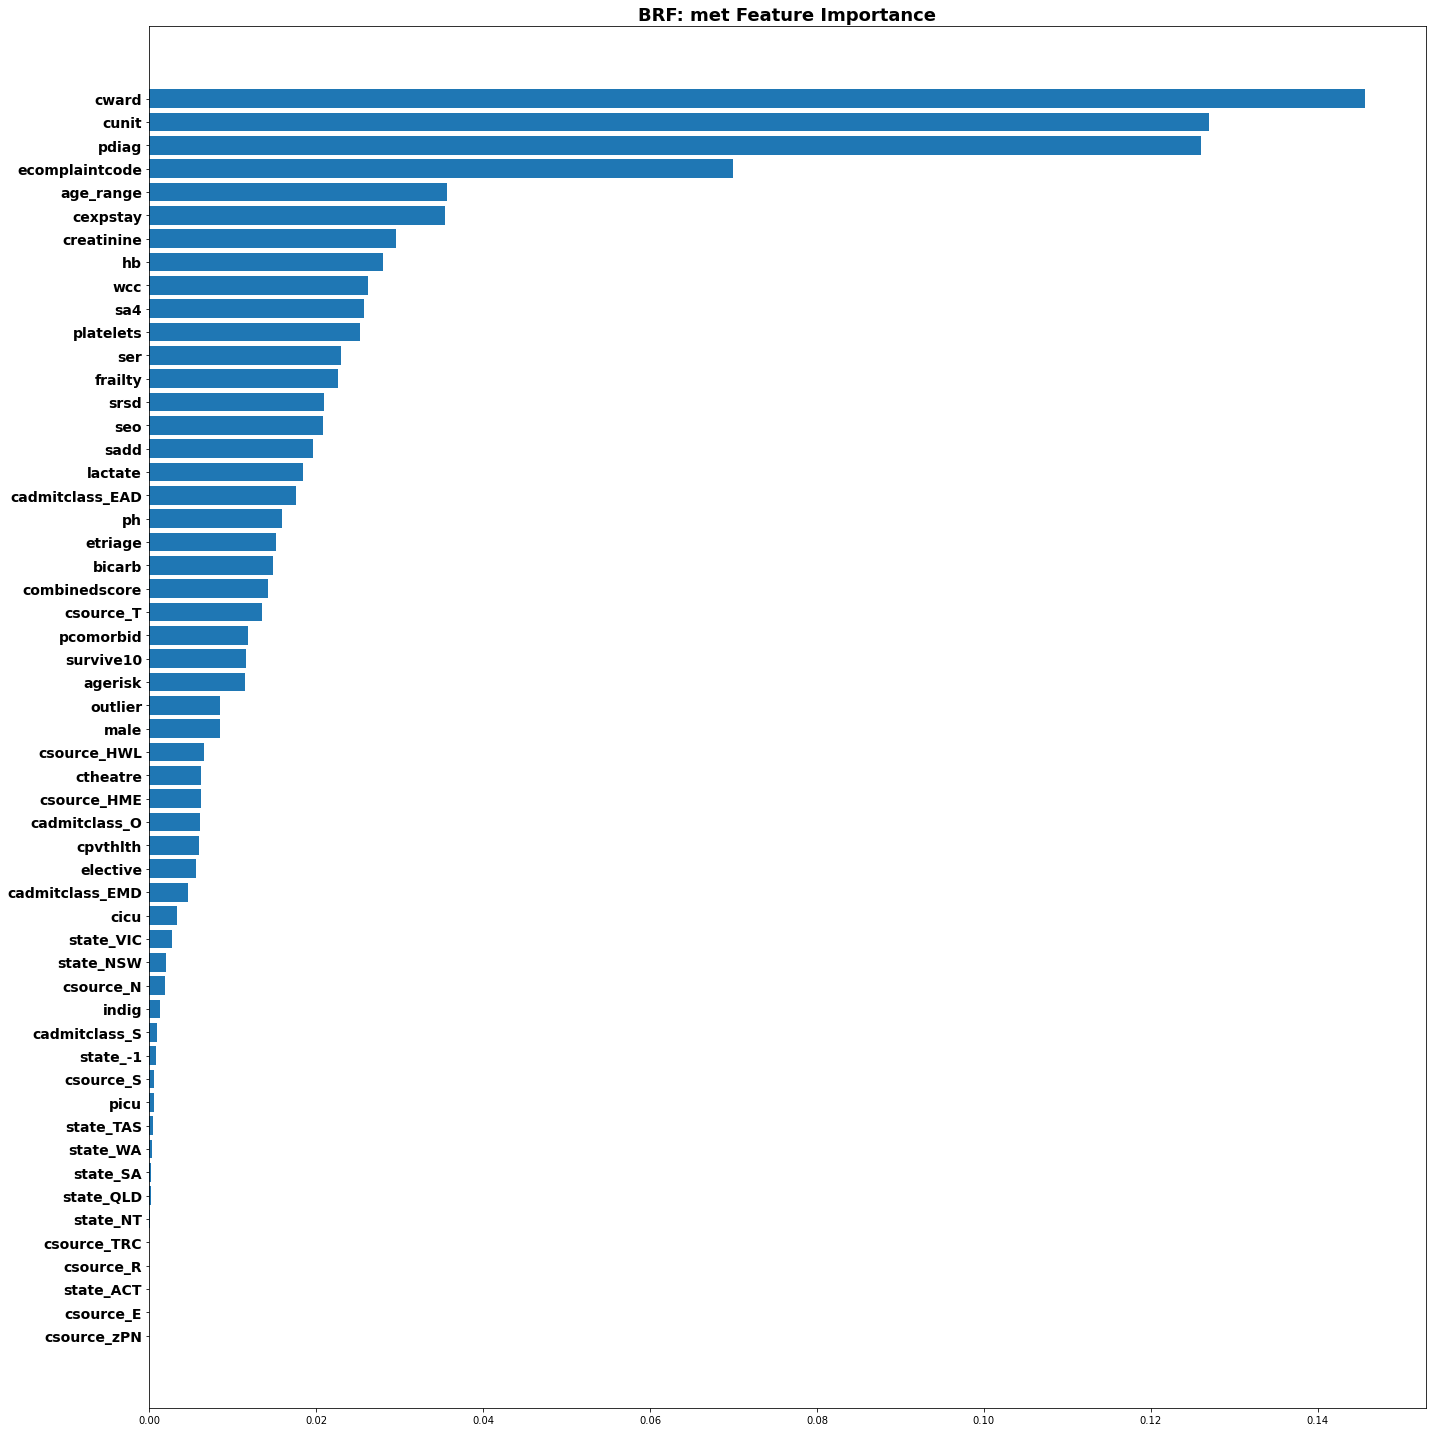

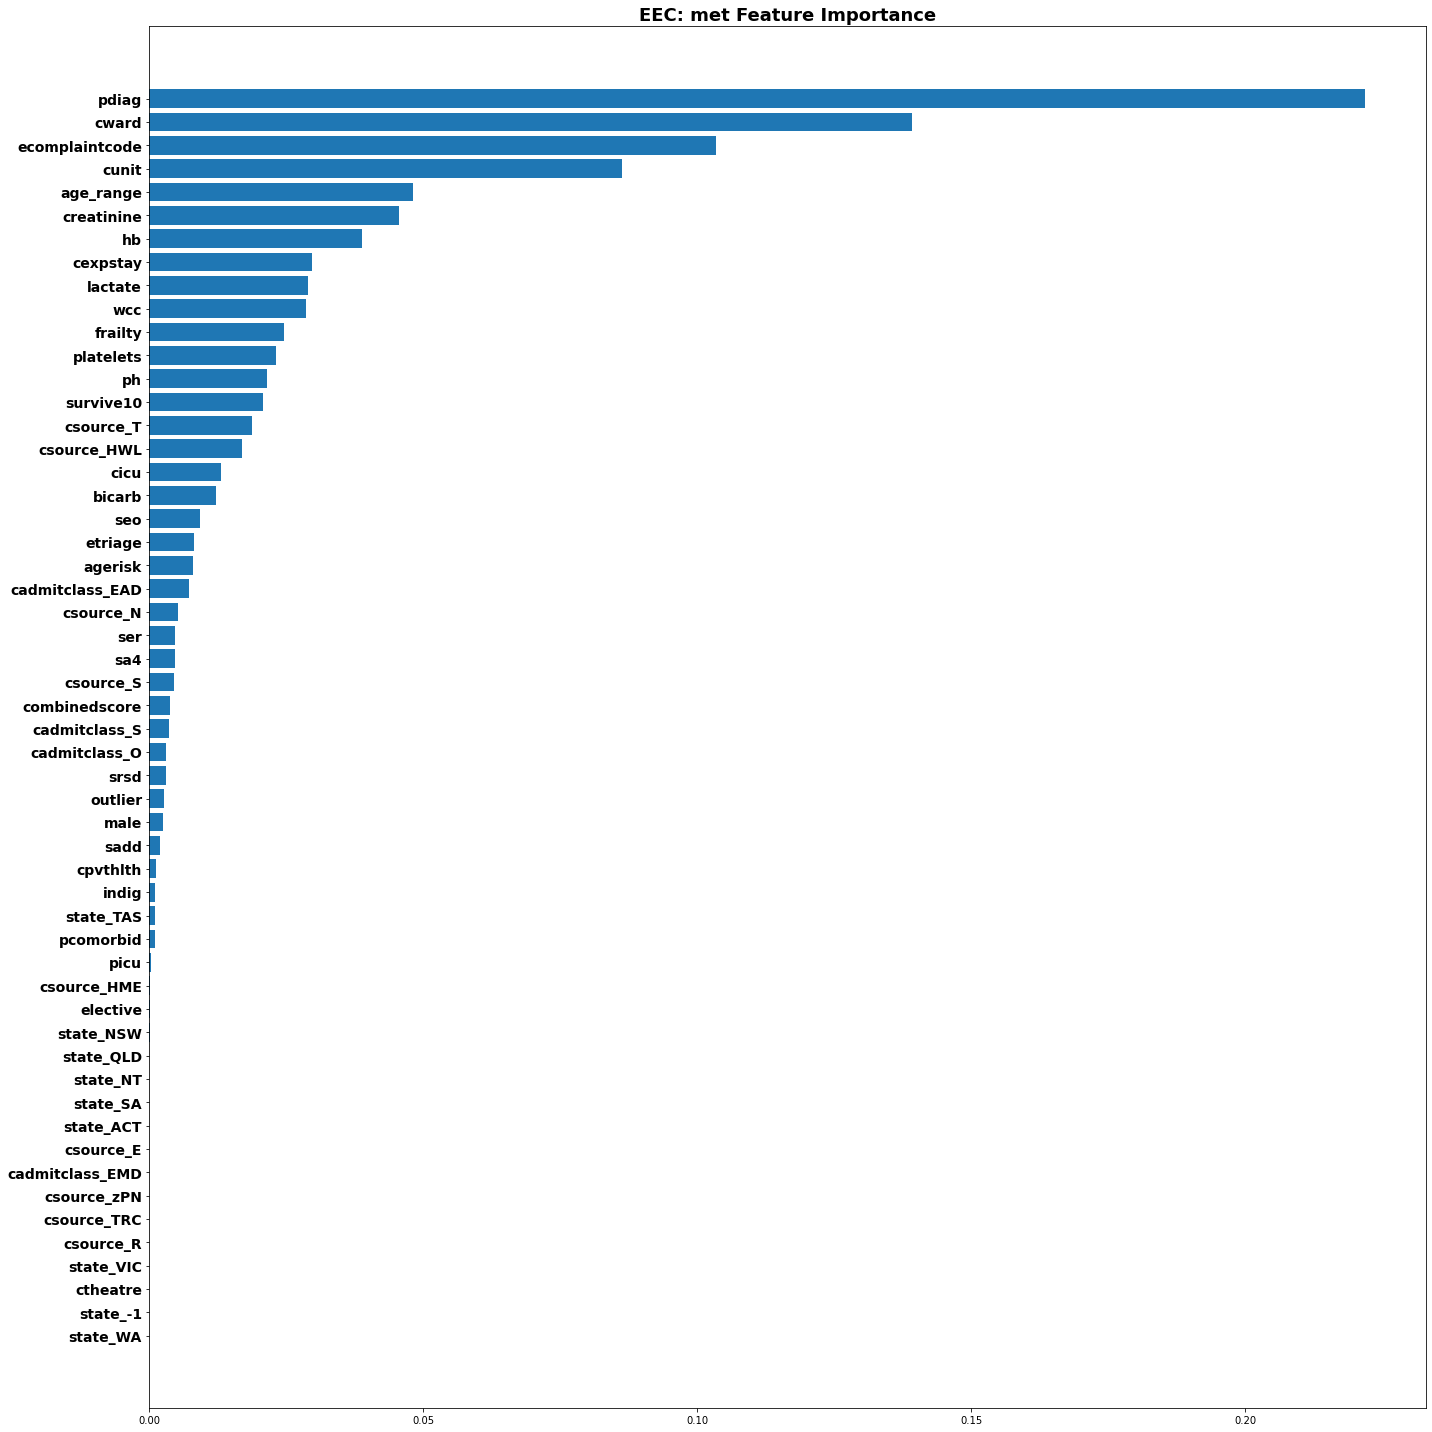

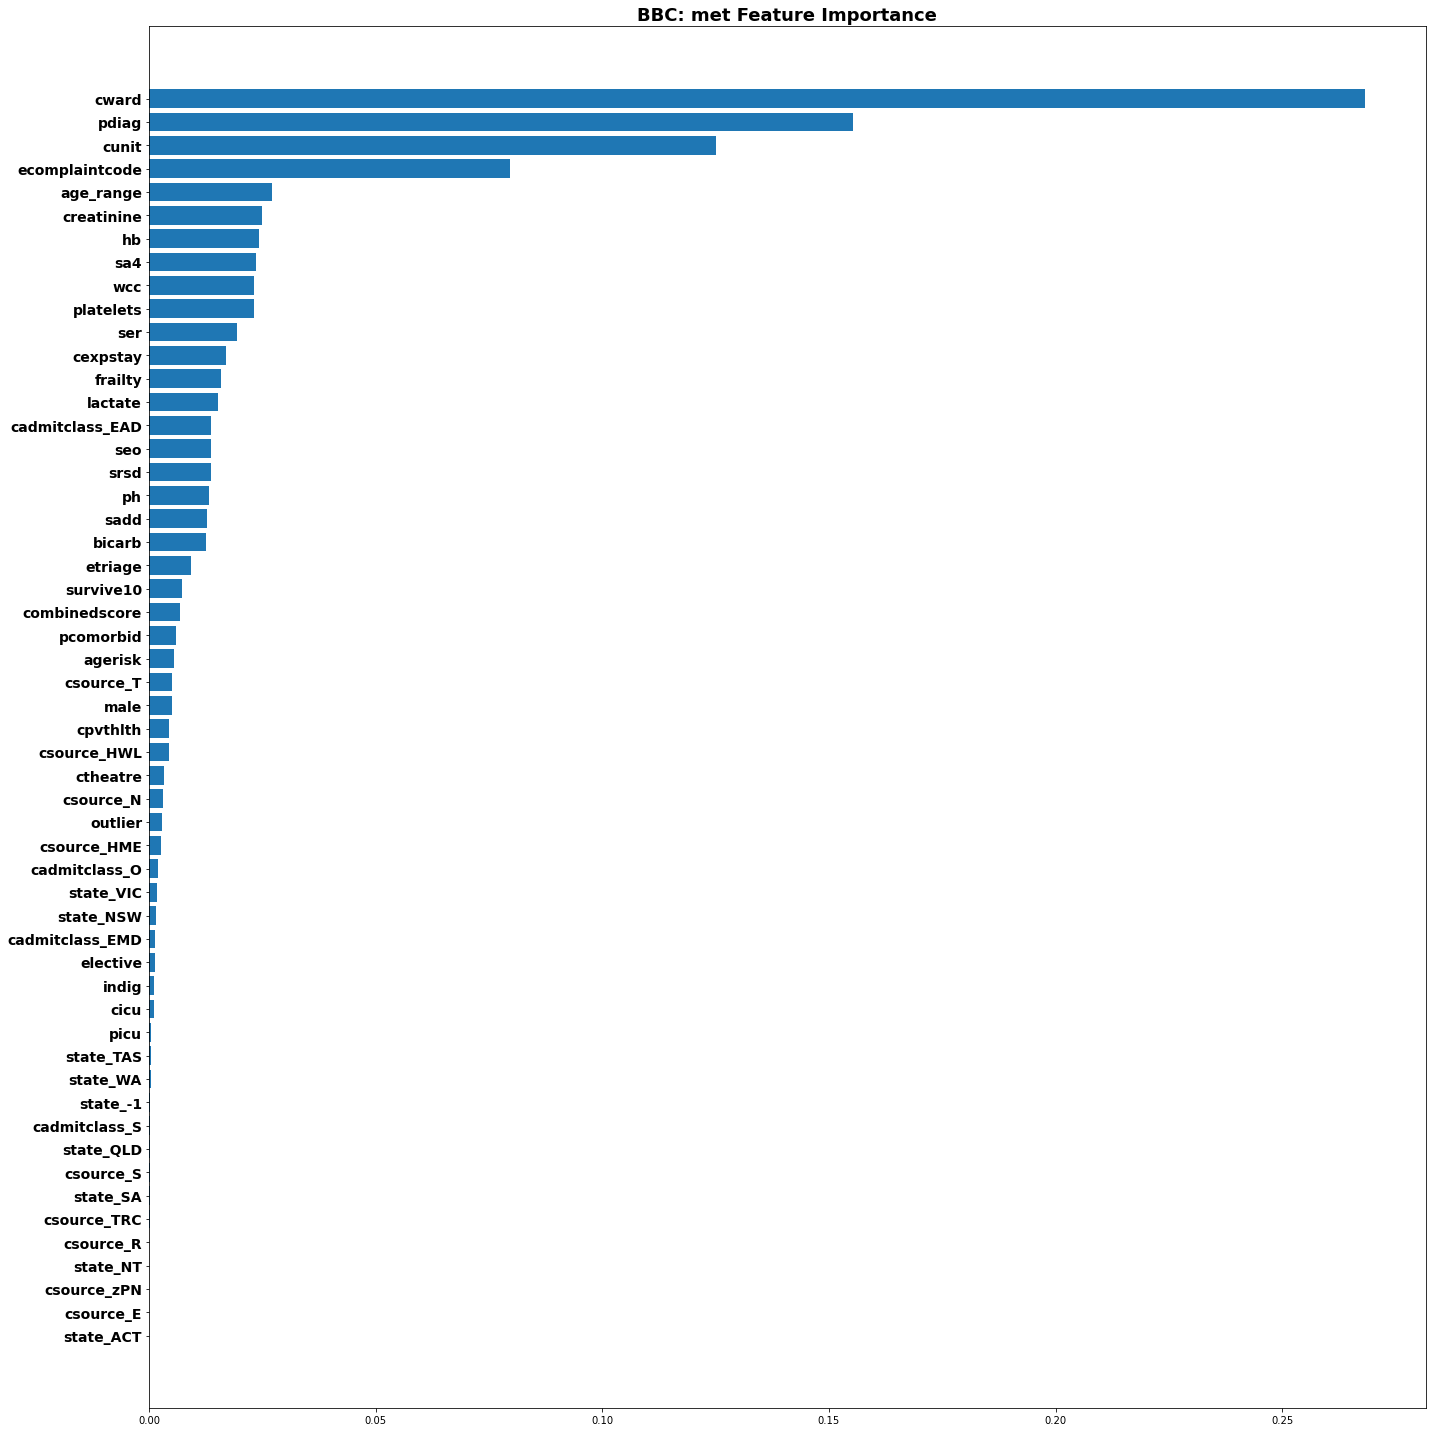

19099

In [9]:

cols = list(X_train.columns)
plt.rcParams['figure.figsize'] = (20.0, 20.0)

def plot_importance(indices, feature_importances, title):    
    sorted_idx = indices[::-1]
    feature_names = np.array(cols)[sorted_idx].tolist()
    y_ticks  = np.arange(0, len(feature_names)) 
    fig, ax = plt.subplots()
    ax.barh(y_ticks,feature_importances[sorted_idx], align='center')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names, weight = 'bold', fontsize=14)
    ax.set_title(title, weight = 'bold', fontsize=18)
    fig.tight_layout()
    #plt.savefig('Fimportance.png')
    plt.show()
    

def get_models():
    models, names = list(), list()
    
    # BRF
    models.append( BalancedRandomForestClassifier(n_estimators=100, n_jobs=-1))
    names.append('BRF')
    # EEC
    models.append( EasyEnsembleClassifier(n_estimators=100, n_jobs=-1)) 
    names.append('EEC')
    # BBC
    models.append( BalancedBaggingClassifier(n_estimators=100, n_jobs=-1))
    names.append('BBC')
    return models, names

indeces = []
# apply encoding on categorical features and then scale the be in standard form (zero mean and unit variance)
X_train_enc = encoder.fit_transform(X_train, y_train)

# define models
models, names = get_models()
# evaluate each model
for i in range(len(models)):
    model = models[i]
    fit = model.fit(X_train_enc, y_train)
    if names[i] == 'BRF':
        importance = -model.feature_importances_
    elif names[i] == 'BBC' or 'EEC':
        importance = -(np.mean([est.steps[1][1].feature_importances_ for est in model.estimators_], axis=0))
    indices_ = np.argsort(importance)
    selected_features_names = np.array(cols)[indices_]
    
    mv_df = pd.DataFrame({'anycall Features importance':np.array(selected_features_names)})
    #with pd.option_context('display.max_columns', None): 
    #    display(mv_df.T)
    indeces.append(indices_)
    plot_importance(indices_, -importance, names[i]+': '+target+' Feature Importance')
gc.collect()

* __Fnding 70 most voted (important) features__

In [10]:
Num_of_imp_features = len(df_met.columns)
most_vote_dict = {k: v for v, k in enumerate(indeces[0])}

ind_list = [indeces[1], indeces[2]]
for lst in ind_list:
    for v, k in enumerate(lst):
        most_vote_dict[k] +=v

most_vote_sorted = {k: v for k, v in sorted(most_vote_dict.items(), key=lambda item: item[1])}
MV_ind = list(most_vote_sorted.keys())
mv_df = pd.DataFrame({'Most important features':np.array(cols)[MV_ind[:Num_of_imp_features]]})
with pd.option_context('display.max_columns', None): 
    display(mv_df.T)

# Select important features
top__features = list(np.array(cols)[MV_ind[:Num_of_imp_features]])

X_Train = X_train[top__features]
print('\nData shape: X:{}  & y:{}'.format(X_Train.shape,y_train.shape))

# handling ram usage
del  cols, most_vote_sorted
gc.collect()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
70 Most important features,cward,pdiag,cunit,ecomplaintcode,age_range,creatinine,hb,cexpstay,wcc,platelets,frailty,lactate,sa4,ser,seo,ph,cadmitclass_EAD,bicarb,srsd,etriage,survive10,csource_T,sadd,combinedscore,agerisk,csource_HWL,pcomorbid,male,outlier,cicu,csource_N,cadmitclass_O,cpvthlth,csource_HME,ctheatre,elective,indig,cadmitclass_S,state_NSW,csource_S,cadmitclass_EMD,state_VIC,picu,state_TAS,state_QLD,state_-1,state_SA,state_WA,state_NT,csource_TRC,csource_R,state_ACT,csource_E,csource_zPN



Data shape: X:(114291, 54)  & y:(114291,)


0

*  #### __TopFeature performance__

In [11]:
space = list(range(50,Num_of_imp_features+1,2))
# define models to test
model = Pipeline(steps=[('prep',encoder),('m',BalancedRandomForestClassifier(n_estimators=150, n_jobs=-1))])
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
scores_list = []
for ind in space:
    X = X_train[top__features[0:ind]]
    # evaluate the pipeline
    metric = make_scorer(recall_score)#sensitivity_score)
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluate model
    scores = cross_val_score(model, X, y_train, scoring=metric, cv=cv, n_jobs=-1, error_score='raise')
    scores_list.append((ind,np.mean(scores)))
    # report pipeline performance
    print('Recall top %s: %.3f (%.3f)' % (str(ind), np.mean(scores), np.std(scores)))

# finding top feature inde
scores_array = np.array([list(item) for item in scores_list])
ind_max_score = np.argmax(scores_array[:,1])
top_feature_ind = int(scores_array[ind_max_score,0])

Recall top 50: 0.711 (0.021)
Recall top 52: 0.714 (0.028)
Recall top 54: 0.716 (0.020)
Recall top 56: 0.714 (0.020)
Recall top 58: 0.714 (0.027)
Recall top 60: 0.714 (0.018)
Recall top 62: 0.709 (0.025)
Recall top 64: 0.713 (0.019)
Recall top 66: 0.707 (0.024)
Recall top 68: 0.716 (0.028)
Recall top 70: 0.714 (0.027)


*  #### __Top Features selection__

In [12]:
X_train = X_train[top__features[0:top_feature_ind]]
X_test  = X_test [top__features[0:top_feature_ind]]

categorical_ix_new = [cat for cat in categorical_ix if cat in top__features]
encoder = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), categorical_ix_new )], remainder='passthrough')

In [13]:
X_train.columns

Index(['cward', 'pdiag', 'cunit', 'ecomplaintcode', 'age_range', 'creatinine',
       'hb', 'cexpstay', 'wcc', 'platelets', 'frailty', 'lactate', 'sa4',
       'ser', 'seo', 'ph', 'cadmitclass_EAD', 'bicarb', 'srsd', 'etriage',
       'survive10', 'csource_T', 'sadd', 'combinedscore', 'agerisk',
       'csource_HWL', 'pcomorbid', 'male', 'outlier', 'cicu', 'csource_N',
       'cadmitclass_O', 'cpvthlth', 'csource_HME', 'ctheatre', 'elective',
       'indig', 'cadmitclass_S', 'state_NSW', 'csource_S', 'cadmitclass_EMD',
       'state_VIC', 'picu', 'state_TAS', 'state_QLD', 'state_-1', 'state_SA',
       'state_WA', 'state_NT', 'csource_TRC', 'csource_R', 'state_ACT',
       'csource_E', 'csource_zPN'],
      dtype='object')

<a class="anchor" id="heading--III"></a>
## 3. Imbalanced Classification

<a class="anchor" id="heading--3-I"></a>
### 3.1. __Model comparison__ 

In [26]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
def get_models():
    models, names = list(), list()
    
    # LR
    model_lr = LogisticRegression(class_weight='balanced',n_jobs=-1)
    models.append(Pipeline(steps=[('prep',encoder),('t1', scaler),('m',model_lr)]))#
    names.append('LR')   
    
    # IHT-LR
    model_lr = LogisticRegression(class_weight='balanced',n_jobs=-1)
    models.append(Pipeline(steps=[('prep',encoder),('t1', scaler),('Under', InstanceHardnessThreshold()),('m',model_lr)]))#
    names.append('IHT-LR')
    
    # CNB
    models.append(Pipeline(steps=[('prep',encoder),('t1', scaler),('m',ComplementNB())]))#
    names.append('CNB')
    
    # RUSC (Balanced Boosting Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('m',RUSBoostClassifier(n_estimators=150))]))#) # 
    names.append('RUSC')      
    
    ## EEC (Balanced Boosting Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('m',EasyEnsembleClassifier(n_estimators=150, n_jobs=-1))]))#
    names.append('EEC')
    
    # BRF (Balanced Bagging Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('m',BalancedRandomForestClassifier(n_estimators=150, n_jobs=-1))]))
    names.append('BRF') 
    
    # IHT-BRF (Balanced Bagging Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('Under', InstanceHardnessThreshold()),('m',BalancedRandomForestClassifier(n_estimators=150, n_jobs=-1))]))
    names.append('IHT-BRF') 
    
    ## BBC (Balanced Bagging Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('m',BalancedBaggingClassifier(n_estimators=150, n_jobs=-1))]))#
    names.append('BBC')
   
    
    return models, names

LR: precision: 0.045110870457851275, recall: 0.8048669180891853, auc_: 0.07084158012820546, Average precision-recall: 0.04936847064891369
IHT-LR: precision: 0.045984811204907064, recall: 0.8171748221814942, auc_: 0.07390011070195387, Average precision-recall: 0.04573737010470067
CNB: precision: 0.04112508935721457, recall: 0.744426380003672, auc_: 0.06274156387708438, Average precision-recall: 0.031764572326905424
RUSC: precision: 0.037278293783423504, recall: 0.7221799119090149, auc_: 0.04990933423339789, Average precision-recall: 0.03534999727943413
EEC: precision: 0.04324693985513283, recall: 0.7705194210706532, auc_: 0.06728862306689479, Average precision-recall: 0.04519524502018006
BRF: precision: 0.06315765833335027, recall: 0.6681219749034604, auc_: 0.07244910504447383, Average precision-recall: 0.046967178531793614
BBC: precision: 0.0658276350908885, recall: 0.5475964534587275, auc_: 0.0682669506230448, Average precision-recall: 0.046958399018736614


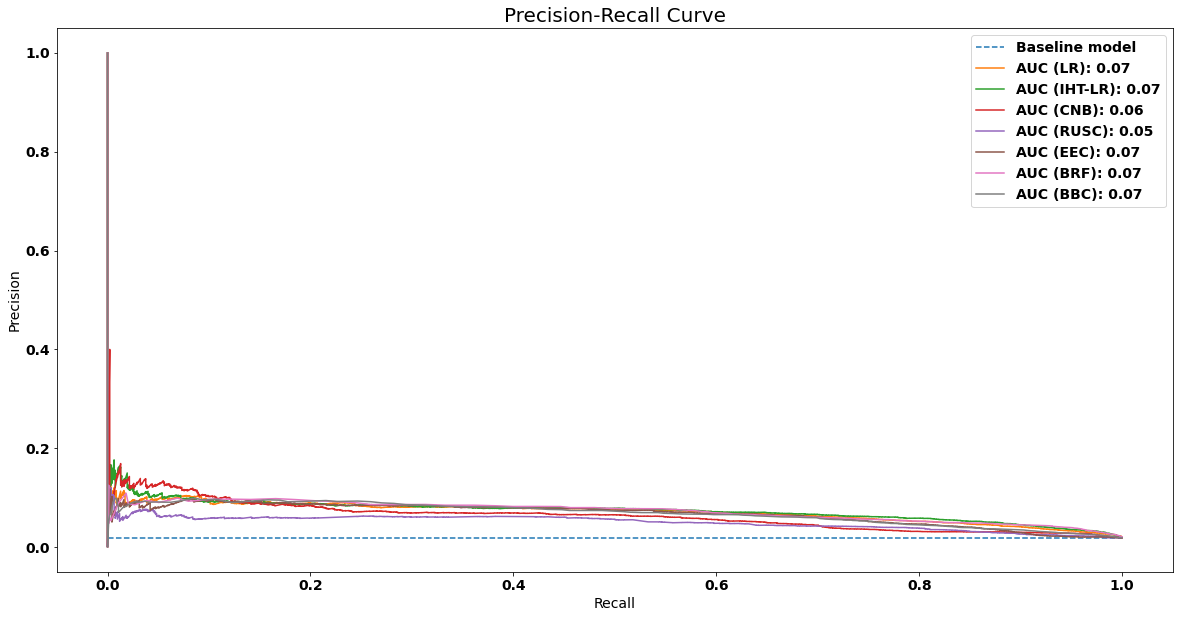

In [27]:
models, names = get_models()
results = list()
PRC_models(models, names, results,X_train, y_train, X_test, y_test)

<a class="anchor" id="heading--3-II"></a>
### 3.2 __Hyperparameter Tuning__ 


In [29]:
def get_models():
    models, names, spaces= list(), list(), list()
    
    model_1r = LogisticRegression(class_weight='balanced',n_jobs=-1)
    pipeline_lr = Pipeline(steps=[('columntransformer',encoder),('t1', scaler),
                                  ('Under', InstanceHardnessThreshold()), ('model', model_1r)
                                 ])
    # LR    
    # define search space
    grid = dict()
    grid['model__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    grid['model__C'] = [1e-5, 1e-3,1e-1, 1, 3]#loguniform(1e-5, 100)#
    models.append(pipeline_lr)#
    names.append('LR')  
    spaces.append(grid)

    model = BalancedRandomForestClassifier( n_jobs=-1)
    pipeline_brf = Pipeline(steps=[('columntransformer',encoder),
                                   ('model', model)])
    # define grid
    grid = dict()
    grid['model__n_estimators'] = [500,700,800,900]
    grid['model__class_weight'] = [{1:1,0:6},{1:1,0:8},{1:1,0:9}]

    models.append(pipeline_brf)
    names.append('BRF') 
    spaces.append(grid)
    
    
    return models, names, spaces

In [30]:
models, names, spaces = get_models()
results = list()
gc_models(models, names, results, spaces, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Training set score: 0.3416784758305779
Test set score: 0.33330623526542563
Best of LR: 0.330219 using {'model__C': 0.1, 'model__solver': 'newton-cg'} 

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Training set score: 0.4167898897892392
Test set score: 0.35030253400664213
Best of BRF: 0.345543 using {'model__class_weight': {1: 1, 0: 8}, 'model__n_estimators': 800} 



* Best model performance

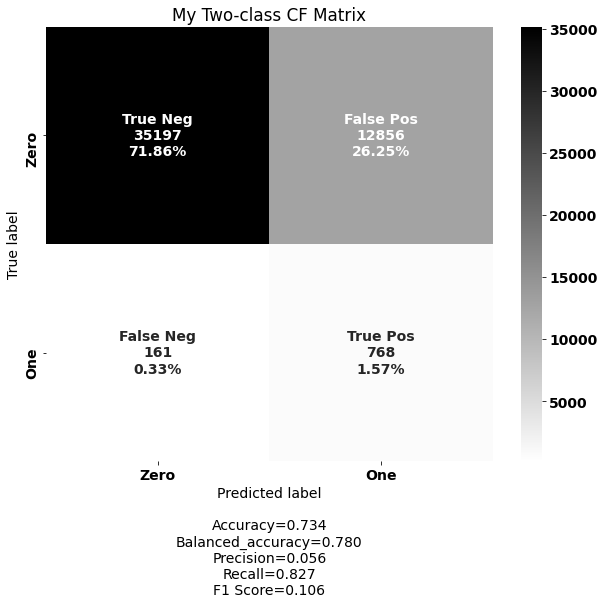

In [43]:
from imblearn.over_sampling        import SMOTE
model_2 = BalancedRandomForestClassifier(n_estimators=800,
                                             class_weight= {1: 1, 0: 8},#{1: 0.51070031, 0: 23.8638058},#{1: 1, 0: 9},#{1: 1, 0: 5},#
                                             n_jobs=-1) 
pipe = Pipeline(steps=[('prep',encoder),('m',model_2)])

'''model_1r = LogisticRegression(class_weight='balanced', C= 0.1, solver= 'newton-cg', n_jobs=-1) 
pipe = pipeline_lr = Pipeline(steps=[('columntransformer',encoder),('t1', scaler),('Under', InstanceHardnessThreshold()),
                                   ('model', model_1r         )])'''

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

cf_matrix = confusion_matrix(y_test, predictions)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title='My Two-class CF Matrix')

#### __Finalize Model¶__


Dataset loaded successfully.
Dimensions of the dataset: (163273, 145)
Data preparation steps:

(1/11) Completed renaming columns
(2/11) Completed keeping the admission record only 
(3/11) Completed training purpose data engineering
(4/11) Completed filtering columns
(5/11) Completed postcode (Feature Engineering).
(6/11) Completed Feature Engineering
(7/11) Completed Droping useless columns
(8/11) Completed missing value handeling
(9/11) Completed data type conversion
(10/11) Completed data type conversion
(11/11) Completed data type conversion
Data Preprocessing complete.
Total Number of remained missing values --> 0
Dimensions of the final dataset: (163272, 59)


Training the model ...

 Training completed!
Predicting the test data ...
Modeling completed


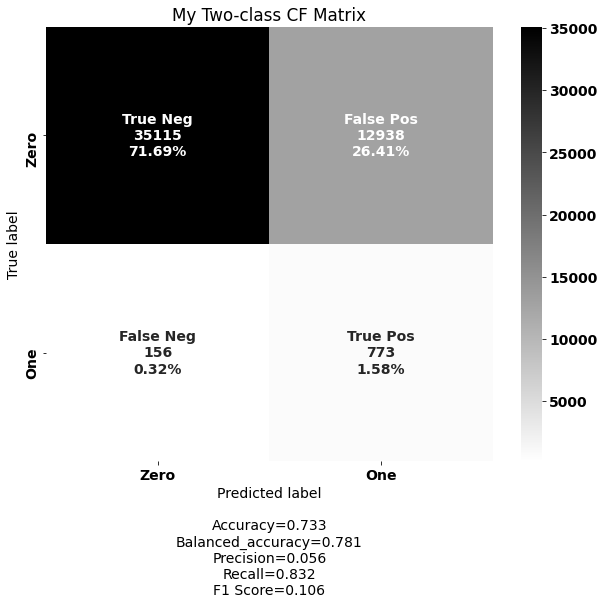

In [3]:
# load @admission file based on 1~167 csv files 
df =  pd.read_csv(data_path+'@admission_allData.csv', low_memory=False)
print('Dataset loaded successfully.\nDimensions of the dataset: {}'.format(df.shape))

# name of dependant variable
target = 'met'

# selected features which are the most important features for the prediction purpose
top_features    = ['cward', 'pdiag', 'cunit', 'ecomplaintcode', 'age_range', 'creatinine',
                   'hb', 'cexpstay', 'wcc', 'platelets', 'frailty', 'lactate', 'sa4',
                   'ser', 'seo', 'ph', 'cadmitclass_EAD', 'bicarb', 'srsd', 'etriage',
                   'survive10', 'csource_T', 'sadd', 'combinedscore', 'agerisk',
                   'csource_HWL', 'pcomorbid', 'male', 'outlier', 'cicu', 'csource_N',
                   'cadmitclass_O', 'cpvthlth', 'csource_HME', 'ctheatre', 'elective',
                   'indig', 'cadmitclass_S', 'state_NSW', 'csource_S', 'cadmitclass_EMD',
                   'state_VIC', 'picu', 'state_TAS', 'state_QLD', 'state_-1', 'state_SA',
                   'state_WA', 'state_NT', 'csource_TRC', 'csource_R', 'state_ACT',
                   'csource_E', 'csource_zPN']


# preparing data for the prediction step
print('Data preparation steps:\n')
# apply preprocessing
df, categorical_ix = mimic_cleanup(df)

# apply feature selection besed on optimal features selected before
df_met2 = df[top_features+ [target]]

# Train and test split
df_train, df_test = train_test_split(df_met2,  stratify = df_met2[target],
                                     test_size = 0.3,
                                     random_state = 42)
X_train, y_train = df_train.drop(  [target], axis=1) , df_train  [target]
X_test,  y_test  = df_test.drop([target], axis=1) , df_test[target]

# Selected encoder and scaler to be applied to the data
encoder = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), categorical_ix )], remainder='passthrough')
scaler  = MinMaxScaler()

# selecting best performing model and making the prediction pipeline
model_2 = BalancedRandomForestClassifier(n_estimators=800,
                                             class_weight= {1: 1, 0: 8},
                                             n_jobs=-1) 
pipe = Pipeline(steps=[('prep',encoder),('m',model_2)])

# fit the model
print('\nTraining the model ...')
pipe.fit(X_train, y_train)
print('\n Training completed!')
# Predict
print('Predicting the test data ...')
predictions = pipe.predict(X_test)
print('Modeling completed')
# display the resutls
cf_matrix = confusion_matrix(y_test, predictions)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title='My Two-class CF Matrix')